In [158]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/


In [225]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [ ]:
dfs = Dataset().get_data(keep_na=False)

In [ ]:
eda_df = dfs[0]

In [211]:
posthoc_columns = [col for col in eda_df.columns if 'posthoc' in col]
#eda_df.drop(posthoc_columns,axis=1,inplace=True)

In [212]:
print(list(eda_df.shape))

[1593, 63]


In [145]:
outcome_def = 'csi_injury'

In [146]:
eda_df.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'GCSEye', 'MotorGCS',
       'VerbalGCS', 'TotalGCS', 'PtCompPainFace', 'PtCompPainHead',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead', 'PassRestraint',
       'Assault', 'ChildAbuse', 'csi_injury', 'EMSArrival', 'NonAmbulatory',
       'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P', 'AVPUDetails_AVPU_U',
       'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan', 'GCSnot15',
       'ReceivedInTransfer_binary', 'PtAmbulatoryPriorArrival_binary',
       'ArrPtIntub_binary', 'PtCompPainNeckMove_binary',
       'CervicalSpineImmobilization_outside_binary', 'helmet_binar

In [147]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df.loc[:,binary_columns].copy() 

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df.loc[:,cont_columns].copy()
cont_eda_data.loc[:,outcome_def] = eda_df.loc[:,outcome_def].copy() #add binary outcome indicator back in

In [148]:
# outcome indicator is double counted
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(1593, 63)
(1593, 59)
(1593, 5)


In [149]:
print(cont_eda_data.head())

                                  GCSEye  MotorGCS  VerbalGCS  TotalGCS  \
id     case_id site control_type                                          
110001 110001  1    case             1.0       1.0        1.0       3.0   
110021 110021  1    case             4.0       6.0        5.0      15.0   
110019 110019  1    case             4.0       6.0        5.0      15.0   
110002 110002  1    case             4.0       6.0        5.0      15.0   
110011 110011  1    case             4.0       6.0        5.0      15.0   

                                  csi_injury  
id     case_id site control_type              
110001 110001  1    case                 1.0  
110021 110021  1    case                 1.0  
110019 110019  1    case                 1.0  
110002 110002  1    case                 1.0  
110011 110011  1    case                 1.0  


In [150]:
print(np.unique(eda_df.index.get_level_values('control_type')))

['case' 'ems' 'moi' 'ran']


# Summary EDA

In [151]:
eda_df.describe()

,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,SubInj_TorsoTrunk,Predisposed,HighriskDiving,HighriskFall,HighriskHanging,HighriskHitByCar,HighriskMVC,HighriskOtherMV,AxialLoadAnyDoc,axialloadtop,Clotheslining,CervicalSpineImmobilization,GCSEye,MotorGCS,VerbalGCS,TotalGCS,PtCompPainFace,PtCompPainHead,PtTenderNeck,PtTenderFace,PtTenderHead,PassRestraint,Assault,ChildAbuse,csi_injury,EMSArrival,NonAmbulatory,AVPUDetails_AVPU_A,AVPUDetails_AVPU_P,AVPUDetails_AVPU_U,AVPUDetails_AVPU_V,AVPUDetails_AVPU_nan,GCSnot15,ReceivedInTransfer_binary,PtAmbulatoryPriorArrival_binary,ArrPtIntub_binary,PtCompPainNeckMove_binary,CervicalSpineImmobilization_outside_binary,helmet_binary,HEENT_binary,Cardiovascular_binary,Respiratory_binary,Gastrointestinal_binary,Musculoskeletal_binary,Neurological_binary,Medications_binary,Xrays_outside_binary,CTPerformed_outside_binary,MRIPerformed_outside_binary,NonVerbal,YoungAdult,HighRiskFallDownStairs,PainNeck_Robust
count,1593.000000,1526.000000,1492.000000,1545.000000,1593.000000,1593.000000,1523.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1568.000000,1593.000000,1593.000000,1495.000000,1593.000000,1593.000000,1593.000000,1556.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.00000,1593.000000,1593.000000,1593.000000,381.000000,104.000000,104.000000,1593.000000,1581.000000,1555.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1496.000000,1593.000000,108.000000,273.000000,357.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,88.000000,88.000000,91.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,0.145637,0.363041,0.119303,0.355340,0.287508,0.376020,0.051215,0.111739,0.045825,0.091023,0.049592,0.003139,0.015694,0.043367,0.001255,0.158192,0.150502,0.033271,0.252982,0.025110,0.010283,0.796610,3.756434,5.669178,4.638418,14.064658,0.058380,0.21720,0.376020,0.045198,0.067169,0.706037,0.451923,0.048077,0.161959,0.865275,0.771704,0.839925,0.011927,0.026993,0.010044,0.111111,0.139987,0.210295,0.116310,0.054614,0.648148,0.487179,0.355742,0.096902,0.018268,0.216044,0.032566,0.072280,0.135822,0.322478,0.511364,0.375000,0.010989,0.183930,0.460138,0.021971,0.357188
std,0.352853,0.481034,0.324253,0.478771,0.452742,0.484537,0.220508,0.315144,0.209172,0.287732,0.217169,0.055954,0.124326,0.203748,0.035422,0.365036,0.357682,0.179399,0.434857,0.156508,0.100914,0.402646,0.781980,1.136604,1.064423,2.872756,0.234535,0.41247,0.484537,0.207803,0.250393,0.456174,0.500093,0.214965,0.368528,0.341537,0.419869,0.366791,0.108592,0.162114,0.099746,0.314368,0.347083,0.407646,0.320704,0.227296,0.479774,0.500754,0.479410,0.295942,0.133974,0.411709,0.177567,0.259053,0.342736,0.467611,0.502735,0.486897,0.104828,0.387549,0.498565,0.146635,0.479321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,6.000000,5.000000,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [14]:
binary_imputed_data = binary_eda_data.fillna(0)
print(binary_eda_data.shape, binary_imputed_data.shape)
binary_corrs = binary_imputed_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')

print(cont_corrs)

(1956, 86) (1956, 86)
             GCSEye  MotorGCS  VerbalGCS  TotalGCS
GCSEye     1.000000  0.809397   0.773794  0.835138
MotorGCS   0.809397  1.000000   0.851174  0.881708
VerbalGCS  0.773794  0.851174   1.000000  0.943086
TotalGCS   0.835138  0.881708   0.943086  1.000000


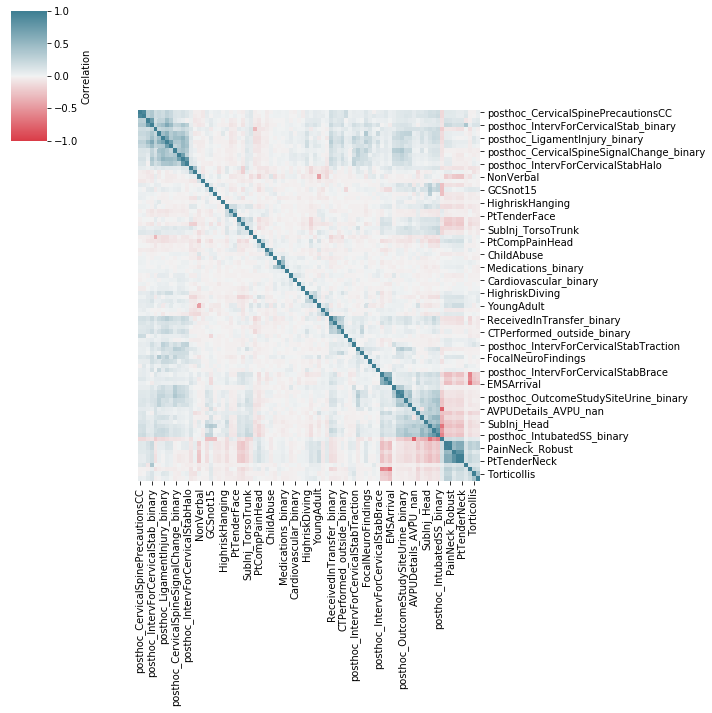

In [15]:
binary_corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
binary_corrmap.ax_row_dendrogram.set_visible(False)
binary_corrmap.ax_col_dendrogram.set_visible(False)

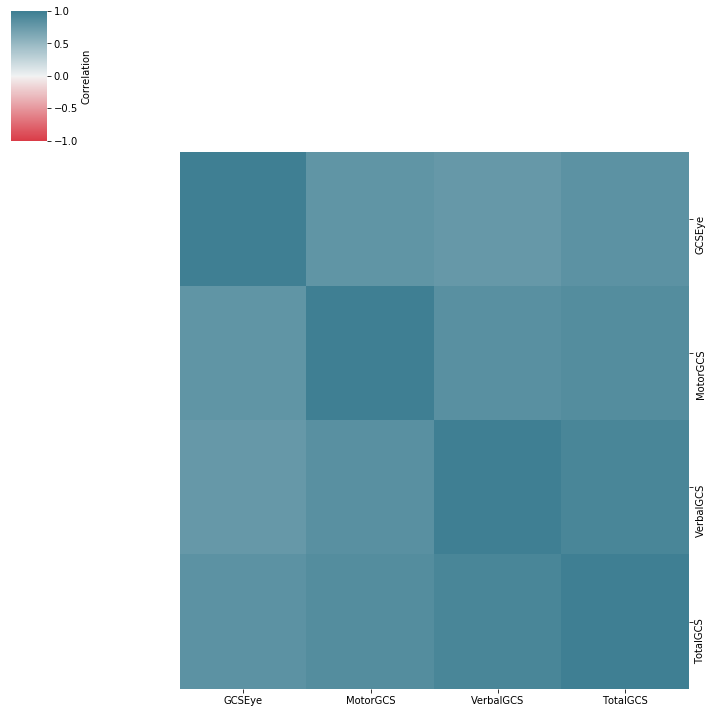

In [16]:
cont_corrmap = sns.clustermap(cont_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
cont_corrmap.ax_row_dendrogram.set_visible(False)
cont_corrmap.ax_col_dendrogram.set_visible(False)

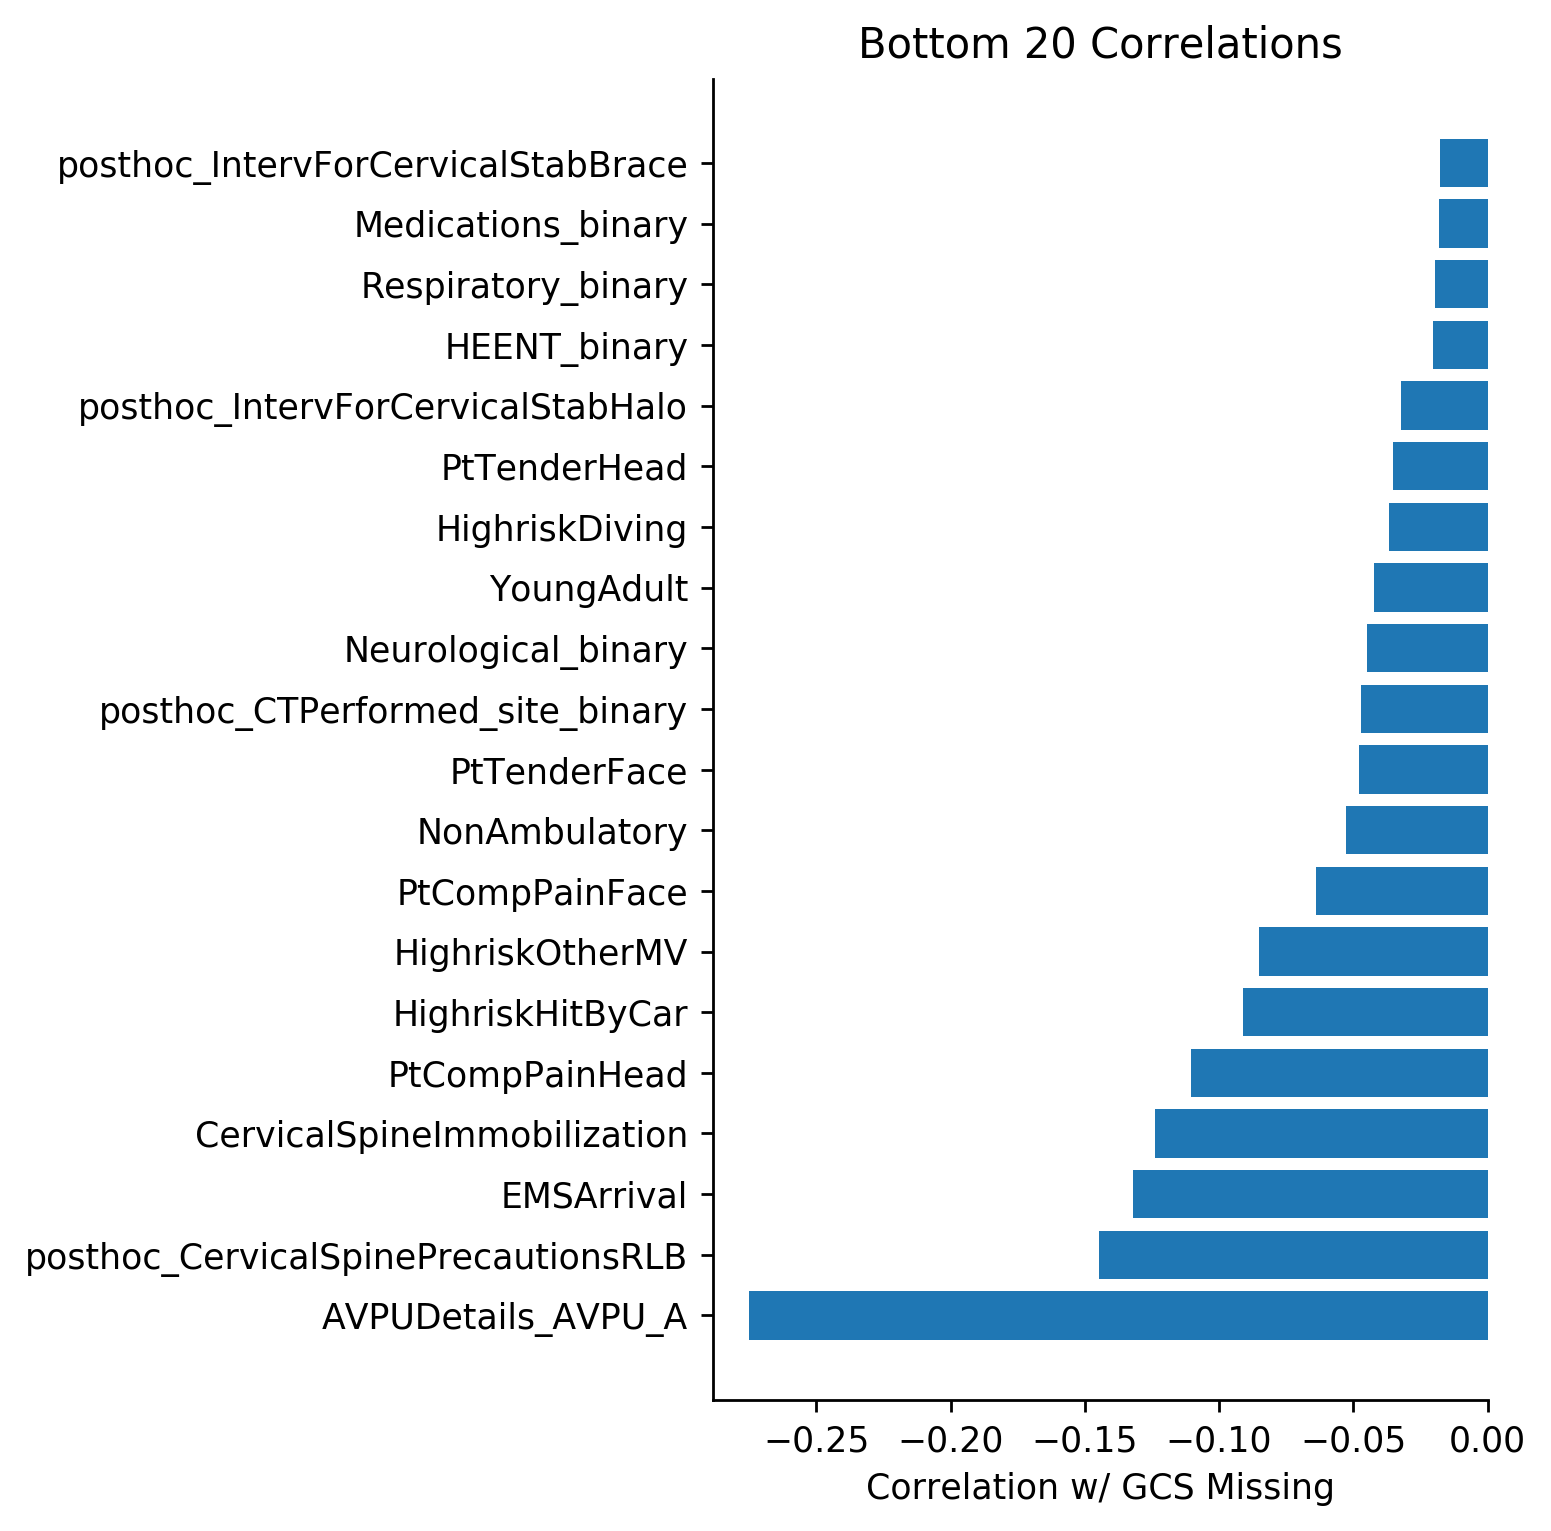

In [17]:
plt.figure(dpi=250, figsize=(4, 7))
#vals = binary_corrs[outcome_def]
vals = binary_corrs['GCSnot15']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:20], vals[args][:20])
plt.xlabel('Correlation w/ GCS Missing')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Bottom 20 Correlations")
plt.show()

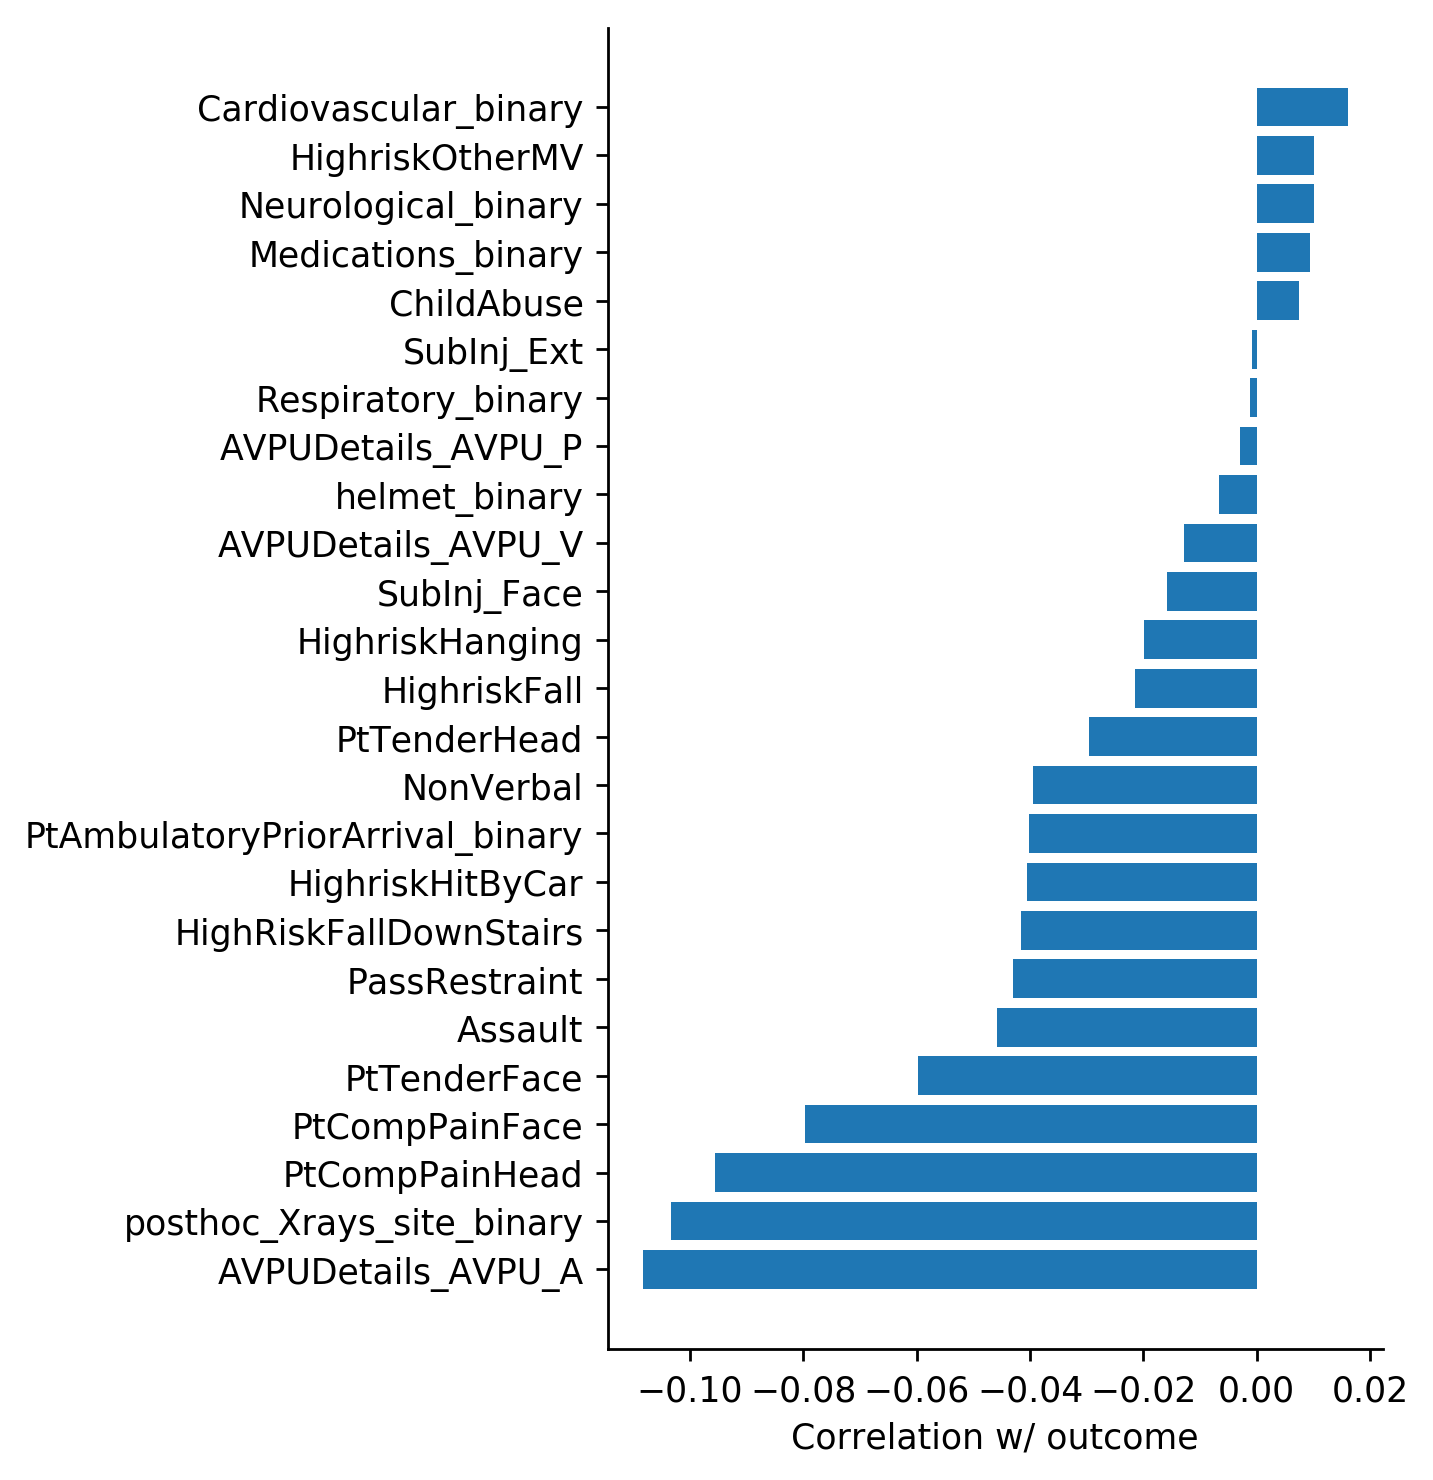

In [18]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs['csi_injury']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

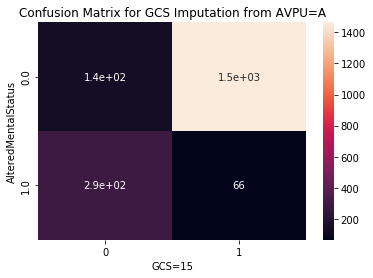

In [19]:
confusion_matrix = pd.crosstab(binary_imputed_data['AlteredMentalStatus'], binary_imputed_data['AVPUDetails_AVPU_A'], rownames=['AlteredMentalStatus'], colnames=['GCS=15'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix for GCS Imputation from AVPU=A")
plt.show()


In [20]:
print(eda_df['TotalGCS'])

id       case_id  site  control_type
110009   110009   1     case             NaN
110017   110017   1     case            15.0
110001   110001   1     case             3.0
110019   110019   1     case            15.0
110012   110012   1     case             NaN
                                        ... 
1723160  1713117  17    ems              NaN
1723133  1713124  17    ems              NaN
1723163  1713132  17    ems             12.0
1723162  1713101  17    ems             15.0
1723138  1713111  17    ems             14.0
Name: TotalGCS, Length: 1956, dtype: float64


In [21]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

KeyError: 'csi_injury'

<Figure size 1000x1750 with 0 Axes>

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(binary_corrs['GCS_NA_total'].sort_values())

# EDA of Missingness

In [64]:
# get percent missing by column
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:])

25 Covariates with Highest Percent Missingness

All Covariates:
ChildAbuse                                    93.660532
Assault                                       93.660532
Xrays_outside_binary                          93.456033
CTPerformed_outside_binary                    93.456033
PtCompPainNeckMove_binary                     93.353783
MRIPerformed_outside_binary                   93.149284
posthoc_OutcomeStudySiteUrine_binary          92.893661
posthoc_OutcomeStudySiteBowel_binary          92.893661
posthoc_OutcomeStudySiteMobility              92.893661
posthoc_OutcomeStudySiteNeuro                 92.893661
posthoc_CervicalSpineSignalChange_binary      91.053170
posthoc_CervicalSpineFractures_binary         83.844581
posthoc_LigamentInjury_binary                 83.844581
CervicalSpineImmobilization_outside_binary    82.413088
helmet_binary                                 78.834356
PassRestraint                                 75.000000
GCSEye                                  

In [72]:
complete_covar = missing_frac[missing_frac==0.]
print("Covar. with no missing data:",len(complete_covar))

missing_columns = missing_frac[missing_frac!=0]
print("Covar. with some missing data:",len(missing_columns))

Covar. with no missing data: 47
Covar. with some missing data: 48


In [83]:
binary_missing_bools = eda_df[missing_columns.index].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

Text(0.5, 1.0, 'Correlation of Missigness by Covariate')

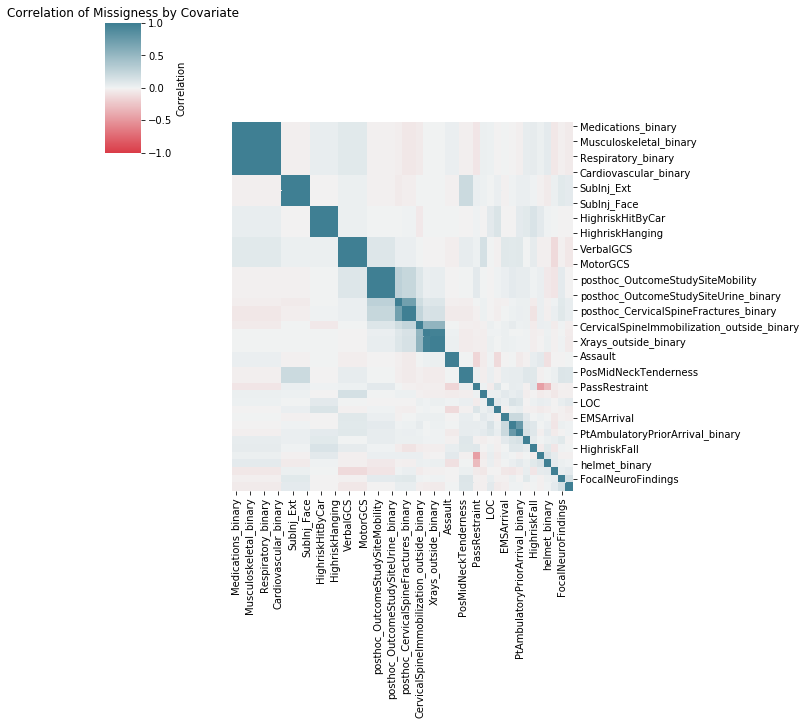

In [84]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
plt.title("Correlation of Missigness by Covariate")

In [ ]:
print(max(binary_missing_corrs))

In [ ]:
print(sorted(binary_missing_corrs.iloc[:,3]))

# EDA of Demographic Data

In [ ]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

In [ ]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
